In this post, we'll look at *overland flow* -- how rainwater drains across a landscape.
The equations of motion are pretty rowdy and have some fascinating effects.
To derive them, we'll start from the shallow water or Saint Venant equations for the water layer thickness $h$ and velocity $u$:

$$\begin{align}
\frac{\partial h}{\partial t} + \nabla\cdot hu & = \dot a \\
\frac{\partial}{\partial t}hu + \nabla\cdot hu\otimes u & = -gh\nabla (b + h) - k|u|u
\end{align}$$

The final term in the momentum equation represents frictional dissipation and $k$ is a (dimensionless) friction coefficient.
Using the shallow water equations for predicting overland flow is challenging because the thickness can go to zero.

For many thin open channel flows, however, the fluid velocity can be expressed purely in terms of the surface slope and other factors.
You could arrive at one such simplification by assuming that the inertial terms in the momentum equation are zero:

$$k|u|u + gh\nabla(b + h) = 0.$$

This approximation is known as the [Darcy-Weisbach equation](https://en.wikipedia.org/wiki/Darcy%E2%80%93Weisbach_equation).
We'll use it in the following because it's simple and it illustrates all the major difficulties.
For serious work, you'd probably want to use the [Manning formula](https://en.wikipedia.org/wiki/Manning_formula), as it has some [theoretical justification](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.88.014501) for turbulent open channel flows.
The overall form of the equation and the resulting numerical challenges are the same in each case.

Putting together the Darcy-Weisbach equation for the velocity with the mass conservation equation gives a single PDE for the water layer thickness:

$$\frac{\partial h}{\partial t} - \nabla\cdot\left(\sqrt{\frac{gh^3}{k}}\frac{\nabla(b + h)}{\sqrt{|\nabla(b + h)|}}\right) = \dot a.$$

This looks like a parabolic equation, but there's a catch!
The diffusion coefficient is proportional to $h^{3/2}$, so it can go to zero when $h = 0$; all the theory for elliptic and parabolic equations assumes that the diffusion coefficient is bounded below.
For a non-degenerate parabolic PDE, disturbances propagate with infinite speed.
For the degenerate problem we're considering, that's no longer true -- the $h = 0$ contour travels with finite speed!
While we're using the Darcy-Weisbach equation to set the velocity here, we still get finite propagation speed if we use the Manning equation instead.
What's important is that the velocity is propertional to some power of the thickness and surface slope.

Eliminating the velocity entirely from the problem is convenient for analysis, but not necessarily the best way to go numerically.
We'll retain the velocity as an unknown, which gives the resulting variational form much of the same character as the mixed discretization of the heat equation.

As our model problem, we'll use the dam break test case from [Santillana and Dawson (2009)](https://doi.org/10.1016/j.cma.2009.11.016).
They discretized the overland flow equations using the *local* discontinuous Galerkin or LDG method, which extends DG for hyperbolic systems to mixed advection-diffusion problems.
We'll use different numerics because Firedrake has all the hipster elements.
I'm eyeballing the shape of the domain from their figures.

In [1]:
import numpy as np
import pygmsh

geometry = pygmsh.built_in.Geometry()

coords = np.array(
    [
        [0.0, 0.0],
        [3.0, 0.0],
        [3.0, 2.0],
        [2.0, 2.0],
        [2.0, 4.0],
        [3.0, 4.0],
        [3.0, 6.0],
        [0.0, 6.0],
        [0.0, 4.0],
        [1.0, 4.0],
        [1.0, 2.0],
        [0.0, 2.0],
    ]
)

points = [
    geometry.add_point(x, lcar=0.125) for x in
    np.column_stack((coords, np.zeros(len(coords))))
]
edges = [
    geometry.add_line(p1, p2) for p1, p2 in
    zip(points, points[1:] + [points[0]])
]

geometry.add_physical(edges)
loop = geometry.add_line_loop(edges)
plane_surface = geometry.add_plane_surface(loop)
geometry.add_physical(plane_surface)

with open("dam.geo", "w") as geo_file:
    geo_file.write(geometry.get_code())
    
!gmsh -2 -format msh2 -v 0 -o dam.msh dam.geo

In [2]:
import firedrake

mesh = firedrake.Mesh("dam.msh")

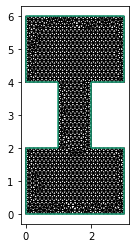

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_aspect("equal")
firedrake.triplot(mesh, axes=ax);

The bed profile consists of an upper, elevated basin, together with a ramp down to a lower basin.

In [4]:
from firedrake import Constant, min_value, max_value

x = firedrake.SpatialCoordinate(mesh)

y_0 = Constant(2.0)
y_1 = Constant(4.0)
b_0 = Constant(0.0)
b_1 = Constant(1.0)
b_expr = b_0 + (b_1 - b_0) * max_value(0, min_value(1, (x[1] - y_0) / (y_1 - y_0)))

S = firedrake.FunctionSpace(mesh, "CG", 1)
b = firedrake.interpolate(b_expr, S)

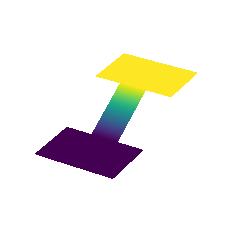

In [5]:
fig = plt.figure()
axes = fig.add_subplot(projection="3d")
axes.set_box_aspect((3.0, 6.0, 1.0))
axes.set_axis_off()
firedrake.trisurf(b, axes=axes);

As I alluded to before, rather than eliminate the velocity entirely, we'll keep it as a field to be solved for explicitly.
The problem we're solving, while degenerate, is pretty similar to the mixed form of the heat equation.
This suggests that we should use element pairs that are stable for mixed Poisson.
Here I'm using the MINI element: continuous linear basis functions for the thickness, and continuous linear enriched with cubic bubbles for the velocity.
We could also have used a more proper $H(\text{div})$-conforming pair, like discontinuous Galerkin for the thickness and Raviart-Thomas or Brezzi-Douglas-Marini for the velocity.

In [6]:
cg1 = firedrake.FiniteElement("CG", "triangle", 1)
Q = firedrake.FunctionSpace(mesh, cg1)
b3 = firedrake.FiniteElement("B", "triangle", 3)
V = firedrake.VectorFunctionSpace(mesh, cg1 + b3)
Z = Q * V

The dam break problem specifies that the thickness is equal to 1 in the upper basin and 0 elsewhere.
I've done a bit of extra work below because the expression for $h$ is discontinuous, and interpolating it directly gives some obvious mesh artifacts.
Instead, I've chosen to project the expression and clamp it above and below.

In [7]:
h_expr = firedrake.conditional(x[1] >= y_1, 1.0, 0.0)
h_0 = firedrake.project(h_expr, Q)
h_0.interpolate(min_value(1, max_value(0, h_0)));

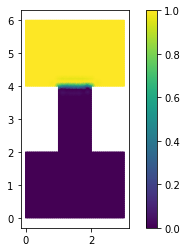

In [8]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(h_0, axes=ax)
fig.colorbar(colors);

In [9]:
z = firedrake.Function(Z)
z_n = firedrake.Function(Z)
δt = Constant(1.0 / 32)
z_n.sub(0).assign(h_0)
z.sub(0).assign(h_0);

The test case in the Santillana and Dawson paper uses a variable friction coefficient in order to simulate the effect of increased drag when flowing over vegetation.

In [10]:
from firedrake import inner

k_0 = Constant(1.0)
δk = Constant(4.0)
r = Constant(0.5)
x_1 = Constant((1.5, 1.0))
x_2 = Constant((1.0, 3.5))
x_3 = Constant((2.0, 2.5))
ψ = sum(
    [
        max_value(0, 1 - inner(x - x_i, x - x_i) / r**2)
        for x_i in [x_1, x_2, x_3]
    ]
)
k = k_0 + δk * ψ

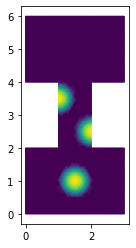

In [11]:
fig, axes = plt.subplots()
axes.set_aspect("equal")
firedrake.tripcolor(firedrake.interpolate(k, S), axes=axes);

The code below defines the variational form of the overland flow equations.

In [12]:
from firedrake import div, grad, dx

g = Constant(1.0)

h, q = firedrake.split(z)
h_n = firedrake.split(z_n)[0]
ϕ, v = firedrake.TestFunctions(Z)

F_h = ((h - h_n) / δt + div(q)) * ϕ * dx
friction = k * inner(q, q)**0.5 * q
gravity = -g * h**3 * grad(b + h)
F_q = inner(friction - gravity, v) * dx
F = F_h + F_q

We'll run into trouble if we try and use a Newton-type method on the true variational form.
Notice how the $q$-$q$ block of the derivative will go to zero whenever $q = 0$.
This will happen whenever the thickness is zero too.
The usual hack is to put a fudge factor $\varepsilon$ into the variational form, as shown below.

In [13]:
ϵ = Constant(1e-3)
friction = k * (inner(q, q) + ϵ**2)**0.5 * q
gravity = -g * h**3 * grad(b + h)
F_qϵ = inner(friction - gravity, v) * dx
F_ϵ = F_h + F_qϵ

The disadvantage of is that we're then solving a slightly different physics problem.
We don't have a great idea ahead of time of what $\varepsilon$ should be either.
If we choose it too large, the deviation from the true problem is large enough that we can't believe the results.
But if we choose it too small, the derivative will fail to be invertible.

We can take a middle course by instead just using the perturbed variational form just to define the derivative in Newton's method, but keep the true variational form as the quantity to find a root for.
To do this, we'll pass the derivative of $F_\varepsilon$ as the Jacobian or `J` argument to the nonlinear variational problem object.
Choosing $\varepsilon$ too small will still cause the solver to crash.
Taking it to be too large, instead of causing us to solve a completely different problem, will now only make the solver go slower instead.
We still want to make $\varepsilon$ as small as possible, but to my mind, getting the right answer slowly is a more tolerable failure mode than getting the wrong answer.

In [14]:
bcs = firedrake.DirichletBC(Z.sub(1), firedrake.zero(), "on_boundary")
J = firedrake.derivative(F_ϵ, z)
problem = firedrake.NonlinearVariationalProblem(F, z, bcs, J=J)

We'll have one final difficulty to overcome -- what happens if the thickness inadvertently becomes negative?
There's a blunt solution that everyone uses, which is to clamp the thickness to 0 from below at every step.
Clamping can work in many cases.
But if you're using a Runge-Kutta method, it only assures positivity at the end of each step and not in any of the intermediate stages.
We can instead formulate the whole problem, including the non-negativity constraint, as a [variational inequality](https://doi.org/10.1137/20M135217X).
Much like how some but not all variational problems arise from minimization principles, some variational inequalities arise from minimization principles with inequality constraints, like the obstacle problem.
But variational inequalities are a more general class of problem than inequality-constrained minimization.
Formulating overland flow as as a variational inequality is a bit of overkill for the time discretization that we're using.
Nonetheless, I'll show how to do that in the following just for illustrative purposes.
We first need two functions representing the upper and lower bounds for the solution.
In this case, the upper bound is infinity.

In [15]:
from firedrake.petsc import PETSc

upper = firedrake.Function(Z)
with upper.dat.vec as upper_vec:
    upper_vec.set(PETSc.INFINITY)

The thickness is bounded below by 0, but there's no lower bound at all on the flux, so we'll set only the flux entries to negative infinity.

In [16]:
lower = firedrake.Function(Z)
with lower.sub(1).dat.vec as lower_vec:
    lower_vec.set(PETSc.NINFINITY)

When we want to solve variational inequalities, we can't use the usual Newton solvers in PETSc -- we have a choice between a semi-smooth Newton (`vinewtonssls`) and an active set solver (`vinewtonrsls`).
I couldn't get the semi-smooth Newton solver to work and I have no idea why.

In [17]:
params = {
    "solver_parameters": {
        "snes_type": "vinewtonrsls",
        "ksp_type": "gmres",
        "pc_type": "lu",
    }
}

solver = firedrake.NonlinearVariationalSolver(problem, **params)

Finally, we'll run the timestepping loop.
Here we pass the bounds explicitly on each call to `solve`.

In [18]:
import tqdm

final_time = 60.0
num_steps = int(final_time / float(δt))

hs = [z.sub(0).copy(deepcopy=True)]
qs = [z.sub(1).copy(deepcopy=True)]

for step in tqdm.trange(num_steps):
    solver.solve(bounds=(lower, upper))
    z_n.assign(z)

    h, q = z.split()
    hs.append(h.copy(deepcopy=True))
    qs.append(q.copy(deepcopy=True))

100%|██████████| 1920/1920 [08:22<00:00,  3.82it/s]


Movie time as always.

In [19]:
%%capture

from matplotlib.animation import FuncAnimation

fig, axes = plt.subplots()
axes.set_aspect("equal")
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)

colors = firedrake.tripcolor(
    hs[0], axes=axes, vmin=0, vmax=1.0, cmap="Blues", num_sample_points=4
)
fn_plotter = firedrake.FunctionPlotter(mesh, num_sample_points=4)

def animate(h):
    colors.set_array(fn_plotter(h))

interval = 1e3 / 60
animation = FuncAnimation(fig, animate, frames=hs, interval=interval)

In [20]:
from IPython.display import HTML

HTML(animation.to_html5_video())

As some a posteriori sanity checking, we can evaluate how much the total water volume deviates.

In [21]:
volumes = np.array([firedrake.assemble(h * dx) for h in hs])
volume_error = (volumes.max() - volumes.min()) / volumes.mean()
print(f"Volume relative error: {volume_error:5.2g}")

Volume relative error: 0.013


Where a truly conservative scheme would exactly preserve the volume up to some small multiple of machine precision, we can only get global conservation up to the mesh resolution with our scheme.
Instead, there are spurious "sources" at the free boundary.
Likewise, there can be spurious sinks in the presence of ablation, so the sign error can go either way.
This topic is covered in depth in [this paper](https://doi.org/10.1137/20M135217X).

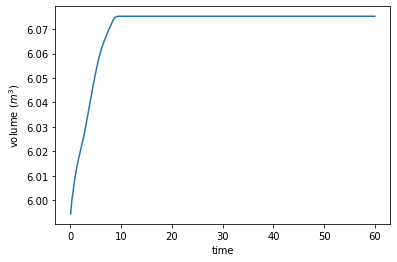

In [22]:
fig, axes = plt.subplots()
ts = np.linspace(0.0, final_time, num_steps + 1)
axes.set_xlabel("time")
axes.set_ylabel("volume ($m^3$)")
axes.plot(ts, volumes);

We can examine the fluxes after the fact in order to see where the value of $\varepsilon$ that we picked sits.

In [23]:
qms = [firedrake.project(inner(q, q)**0.5, Q) for q in qs]
area = firedrake.assemble(Constant(1) * dx(mesh))
qavgs = np.array([firedrake.assemble(q * dx) / area for q in qms])
print(f"Average flux: {qavgs.mean()*100**2:5.1f} cm²/s")
print(f"Fudge flux:   {float(ϵ)*100**2:5.1f} cm²/s")

Average flux: 266.5 cm²/s
Fudge flux:    10.0 cm²/s


The fudge flux is 1/25 that of the average.
This is quite a bit smaller, but not so much so that we should feel comfortable with this large a perturbation to the physics equations themselves.
The ability to use it only in the derivative and not in the residual is a huge help.

To wrap things up, the overland flow equations are a perfect demonstration of how trivially equivalent forms of the same physical problem can yield vastly different discretizations.
Writing the system as a single parabolic PDE might seem simplest, but there are several potential zeros in the denominator that require some form of regularization.
By contrast, using a mixed form introduces more unknowns and a nonlinear equation for the flux, but there's wiggle room within that nonlinear equation.
This makes it much easier to come up with a robust solution procedure, even if it includes a few uncomfortable hacks like using a different Jacobian from that of the true problem.
Finally, while our discretization still works ok with no positivity constraint, PETSc has variational inequality solvers that make it possible to enforce positivity.